# **Music Theme Recognition**

Chuang Caleb
20204134


## **Package Imports**


In [11]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import VarianceThreshold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

from mtr_utils.feature_selection.load_feature_set import load_presel_features

FileNotFoundError: [Errno 2] No such file or directory: 'training_model/mtr_utils/feature_selection/feature_set.json'

## **Choosing Parameters**


Load manually preselected/shortlisted features

In [10]:
preselected_feature_list = load_presel_features()

NameError: name 'load_presel_features' is not defined

In [586]:
target_label = 'risk'
# feature_start = 'Vertical_Unisons'
# feature_end = 'Minor_Major_Triad_Ratio'

k_value = 3

threshold_val = 0

max_leaf_nodes = 10

rand_state = 15



## **Importing Dataset**


#### Features


In [7]:
# Access song_theme_feature_database
song_theme_feature_database_path = '../data/features/song_theme_feature_database.csv'
raw_feature_df = pd.read_csv(song_theme_feature_database_path)

#### Labels


In [588]:
# Access song_theme_labels_database
song_theme_label_database_path = '../data/song_theme_label_database.xlsx'
raw_label_df = pd.read_excel(song_theme_label_database_path)


## **Prepare datasets**


### Manual Selection

Select the features for this iteration


In [9]:
# man_feature_df = raw_feature_df.loc[:, feature_start:feature_end]
man_feature_df = raw_feature_df[preselected_feature_list]


NameError: name 'preselected_feature_list' is not defined

Select the labels for this iteration


In [8]:
# Filter for only recognized samples in labels_df
main_label_df = raw_label_df[raw_label_df.recognizable == 1]

# Filter out unused labels and metadata
main_label_df.drop(
    columns=main_label_df.columns[19:], axis=1, inplace=True)  # unused labels
main_label_df.drop(
    columns=main_label_df.columns[0:4], axis=1, inplace=True)  # metadata

# label_df = main_label_df
# label_df = main_label_df[target_label]
label_df = main_label_df[[target_label]]


NameError: name 'raw_label_df' is not defined

### Feature Selection


Filter out features with zero variance


In [591]:
constant_filter = VarianceThreshold(threshold=threshold_val)
constant_filter.fit(man_feature_df)
constant_columns = [column for column in man_feature_df.columns
                    if column not in
                    man_feature_df.columns[constant_filter.get_support()]]
var_feature_np = constant_filter.transform(man_feature_df)
# x_test = constant_filter.transform(label_df)
# for column in constant_columns:
#     print("Removed ", column)
print(f"Started with {man_feature_df.shape[1]} features.")
print(
    f"Removed {len(constant_columns)} feature(s) that having variance of {threshold_val}.")
print(f"There are {(var_feature_np.shape[1])} features left.")

feature_names = [
    x for x in man_feature_df.columns if not x in constant_columns]


Started with 199 features.
Removed 1 feature(s) that having variance of 0.
There are 198 features left.


Filter out features with low importance


## **Transforming Data**


In [592]:
# from numpy import ravel

# feature_np = feature_df.to_numpy()
# label_np = label_df.to_numpy()
# # feature_np = feature_df
# # label_np = label_df

# feature_np = feature_df.to_numpy()
feature_np = var_feature_np
label_np = label_df.to_numpy().astype(int)

ids_df = raw_feature_df['sample']


### Splitting dataset


In [593]:
(x_train, x_test, y_train, y_test, ids_train, ids_test) = train_test_split(
    feature_np, label_np, ids_df, test_size=0.2, random_state=rand_state)


### Sampling Data

For balanced dataset


In [594]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0,shrinkage= 0.4)
# X_resampled, y_resampled = ros.fit_resample(x_train, y_train)

# from collections import Counter
# print(sorted(Counter(y_resampled).items()))


In [595]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(x_train, y_train)

# from collections import Counter
# print(sorted(Counter(y_resampled).items()))


In [596]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=rand_state)
# x_train, y_train = smote.fit_resample(x_train, y_train)

# y_train.value_counts()


## **Working Model**


In [597]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.pipeline import make_pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_validate


# model_with_selection = make_pipeline(
#     SelectKBest(score_func=f_classif, k=2),
#     RandomForestClassifier(n_jobs=2),
# )

# label_np = ravel(label_np)

# cv_results_with_selection = cross_validate(
#     model_with_selection, feature_np, label_np, return_estimator=True)
# cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

# cv_results_with_selection


In [598]:
from sklearn.tree import DecisionTreeClassifier

knn_parameters = {'k': range(3, 5), 's': [0.5, 0.7, 1.0]}
score = 'f1_macro'

# from imblearn.ensemble import BalancedRandomForestClassifier

# classifier = GridSearchCV(MLkNN(), knn_parameters, scoring=score)
# classifier = MLkNN()

# classifier = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=rand_state) # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree%20classifier#sklearn.tree.DecisionTreeClassifier


dt_parameters = {
    'max_leaf_nodes': range(3, 15),
    'criterion': ["gini", "entropy"]
}
gscv_dt_classifier = GridSearchCV(
    DecisionTreeClassifier(random_state=rand_state),
    param_grid=dt_parameters,
    refit=True,
    cv=5,
    scoring=score,
    error_score='raise'
)
# Fit with entire dataset
gscv_dt_classifier.fit(feature_np, label_np)



# Now get the best performing hyperparameters and we will use it by itself
best_estimator = gscv_dt_classifier.best_estimator_
print(best_estimator)
best_max_leaf_nodes = gscv_dt_classifier.best_params_['max_leaf_nodes']


# Build model and evaluate
# classifier = BalancedRandomForestClassifier(n_estimators=500, random_state=rand_state)
# classifier.fit(x_train, y_train)
best_estimator.fit(x_train, y_train)
# y_predicted = best_estimator.predict(x_test)
best_score = best_estimator.score(x_test, y_test)
best_score

# print(classifier.best_params_, classifier.best_score_)
# classifier.fit(X_resampled, y_resampled)


DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=7, random_state=15)


0.7307692307692307

Text(0.5, 1.0, "'risk' with DecisionTreeClassifier(max_leaf_nodes=7, random_state=15)")

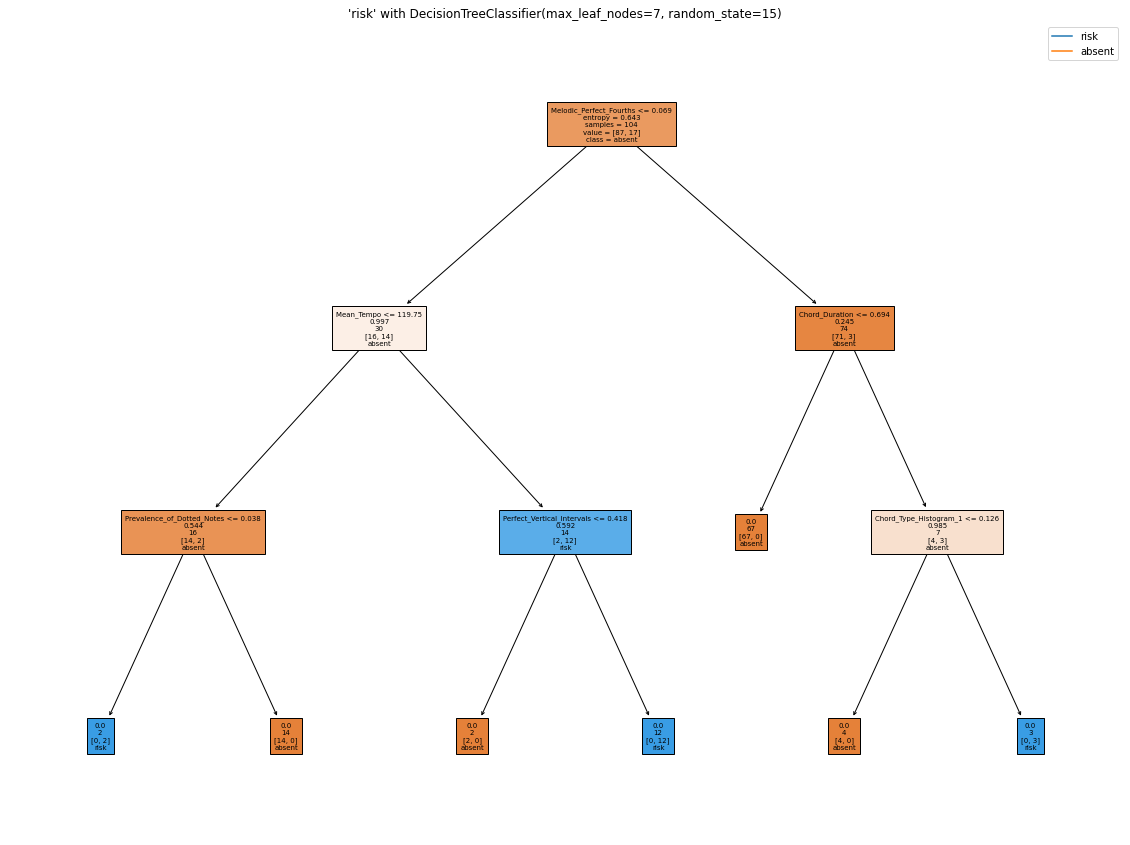

In [599]:
from sklearn import tree
import matplotlib.pyplot as plt

# print(export_text(classifier, feature_names=final_columns))

tree_to_plot = gscv_dt_classifier.best_estimator_
# tree_to_plot = best_estimator

# Figure size
plt.figure(figsize=(20, 15))

# Main plot
tree.plot_tree(tree_to_plot, feature_names=feature_names, class_names=[
               'absent', target_label], label='root', filled=True, fontsize=7)


# Labels
plt.plot(target_label, label=target_label)
plt.plot('absent', label='absent')
plt.legend(loc='upper right')

# Title
plt.title(f"\'{target_label}\' with DecisionTreeClassifier(max_leaf_nodes={best_max_leaf_nodes}, random_state={rand_state})")
# plt.show()


## **Evaluation**


### Prediction


In [600]:
predictions = best_estimator.predict(x_test)


### Metrics


In [603]:
# scores = cross_val_score(classifier, x_test, y_test, cv=3, scoring='accuracy')

print(f'Accuracy: {accuracy_score(y_test, predictions)}')
print(f'Haming Loss: {hamming_loss(y_test, predictions)}')
print(f'F1-score: {f1_score(y_test, predictions)}')


Accuracy: 0.7307692307692307
Haming Loss: 0.2692307692307692
F1-score: 0.2222222222222222


Display results


In [602]:
predictions_df = pd.DataFrame(predictions, columns=label_df.columns)
y_test_df = pd.DataFrame(predictions, columns=label_df.columns)

results = pd.DataFrame(
    # {'sample': ids_test, 'y_true': flat_y_true, 'y_pred': flat_predictions})
    # {'sample': ids_test, 'y_true': y_test, 'y_pred': predictions})
    {'sample': ids_test.reset_index(drop=True), 'y_true': y_test_df[target_label], 'y_pred': predictions_df[target_label]})

results = results.sort_index()

results


,sample,y_true,y_pred
0,court.mid,1,1
1,adele-rolling_in_the_deep_bitmidi.mid,0,0
2,coldplay-a_sky_full_of_stars_bitmidi.mid,0,0
3,braveheart_bitmidi.mid,0,0
4,Romantic_Flight Finale.mid,0,0
5,I Just Can't Wait To Be King.BSO The Lion King...,0,0
6,Disney Themes_The Bear Necessities_midiworld.mid,0,0
7,Billy Joel - Uptown Girl_bitmidi.mid,0,0
8,allstar_bitmidi.mid,0,0
9,Happy-Birthday-2_bitmidi.mid,0,0
